In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

In [84]:
PROCESSED_DATA = './ICDAR/ICDAR_Processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')
ORIG_DATA_PATH = '.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth'

In [14]:
os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('cTDaR_t00005.xml')
root = tree.getroot()

In [23]:
# Function to set a value in the table
def set_value(table, row, col, value):
    table[(row, col)] = value

# Function to get a value from the table
def get_value(table, row, col):
    return table.get((row, col), None)

# Point Extraction from XMLS

### Extraction and arrangement of points for columns from XMLs

In [24]:
import math
def parrange(start_row, start_col, end_row, end_col, pointsfornow, points):
  if(end_row == None):
    end_row = start_row
  if(end_col == None):
    end_col = start_col
  rows = end_row - start_row + 1
  cols = end_col - start_col + 1
  if(rows == 1 and cols == 1):
    set_value(pointsfornow, start_row, start_col, points[0:4])
    set_value(pointsfornow, start_row, start_col, [points[0], points[1], points[math.floor((len(points)-2)/2)+1], points[math.floor((len(points)-2)/2)+2]])
  elif (rows != 1 or cols != 1) and len(points) > 4:
    left = points[:rows+1]
    top = points[rows+1:rows+cols]
    right = points[rows+cols:rows+cols+rows+1]
    bottom = points[rows+cols+rows+1:]
    right.reverse()
    bottom.reverse()
    pts1 = True if len(points) == 2*(rows+cols) else False
    L1 = True if len(left) == rows+1 else False
    R1 = True if len(left) == rows+1 else False
    T1 = True if  len(top) == cols-1 else False
    B1 = True if  len(bottom) == cols-1 else False
    master = True if pts1 and L1 and R1 and T1 and B1 else False
    for row in range(rows):
      for col in range(cols):
        if col == 0 and cols > 1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [left[row], left[row+1], top[col], bottom[col]])
        elif col == cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], right[row], right[row+1]])
        elif col > 0 and col < cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], top[col], bottom[col]])
        else:
          set_value(pointsfornow, start_row+row, start_col+col, None)

In [26]:
def string_to_points(coord_string):
    points = coord_string.split()
    return [tuple(map(int, point.split(','))) for point in points]


In [28]:
def getall(root):
  table= []
  all_points = []
  max_col = []  # Variable to track the maximum end-col value

  for child in root: #Tables in Document
      pointsfornow = {}
      mxc = 0
      for child2 in child: #coord for table and cell in Table
        if 'points' in child2.attrib:
              table.append(string_to_points(child2.attrib['points']))
        else:
            start_row, start_col, end_row, end_col = None, None, None, None
            try:
              start_row = int(child2.attrib['start-row'])
              start_col = int(child2.attrib['start-col'])
              end_row = int(child2.attrib['end-row'])
              end_col = int(child2.attrib['end-col'])
            except(ValueError, TypeError):
              print("exception in Start/End Row/Column")
            try:
              if end_col > mxc:
                mxc = end_col
            except (ValueError, TypeError):
              print("exception in max col")
              if start_col > mxc:
                mxc = start_col
        for child3 in child2: #coord in Cell within Table
          if 'points' in child3.attrib:
                  parrange(start_row, start_col, end_row, end_col, pointsfornow, string_to_points(child3.attrib['points']))
      all_points.append(pointsfornow)
      max_col.append(mxc+1)
  return table, all_points, max_col 

## THIS is for COLUMN MASK ONLY

In [29]:
def customsort(points):
  toreturn = []
  for unsorted_dict in points:
    sorted_dict = dict(sorted(unsorted_dict.items(), key=lambda item: (item[0][0], item[0][1])))
    toreturn.append(sorted_dict)
  return toreturn

In [30]:
def toplot(all_poins, max_col):
    ret = []
    resultant = list(all_poins.items())[-max_col:]
    replacefrm = list(all_poins.items())[:max_col]
    R1 = resultant[0][0][0]
    R2 = replacefrm[0][0][0]
    resultant = dict(resultant)
    replacefrm = dict(replacefrm)
    print(resultant)
    print(replacefrm)
    for i in range(max_col):
      j, k = 1, 1
      res, rep = resultant[(R1, i)],  replacefrm[(R2, i)]
      while res == None:
        res= all_poins[(R1 - j, i)]
        j = j+1
      while rep == None:
        rep = all_poins[(R2 + k, i)]
        k = k+1
      res[0] = rep[0]
      res[3] = rep[3]
      res[0], res[1], res[2], res[3] = list(res[0]), list(res[1]), list(res[2]), list(res[3])
      res[0][0] += 40
      res[1][0] += 40
      res[2][0] -= 40
      res[3][0] -= 40
      res[0], res[1], res[2], res[3] = tuple(res[0]), tuple(res[1]), tuple(res[2]), tuple(res[3])
      ret.append(res)
    return ret

# Mask Generation

In [ ]:
from PIL import Image, ImageDraw

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

In [ ]:
def trailplot(resultant, image_path):
# Define the size of the bitmap
  # width = 10000
  # height = 10000
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)
  closed_areas = [[(951, 501), (875, 3179), (924, 3181), (1003, 503)],
 [(1083, 503), (1004, 3181), (1463, 3193), (1541, 515)],
 [(1621, 515), (1543, 3193), (1640, 3197), (1717, 519)],
 [(1797, 519), (1720, 3197), (1913, 3203), (1983, 525)],
 [(2063, 525), (1993, 3203), (2419, 3214), (2487, 536)],
 [(2567, 536), (2499, 3214), (2603, 3218), (2656, 540)],
 [(2736, 540), (2683, 3218), (2866, 3224), (2908, 546)],
 [(2988, 546), (2946, 3224), (3406, 3236), (3450, 558)],
 [(3530, 558), (3486, 3236), (3588, 3241), (3631, 562)],
 [(3711, 562), (3668, 3241), (3857, 3248), (3903, 569)],
 [(3983, 569), (3937, 3248), (4412, 3261), (4453, 582)]]

# Draw the closed areas in white
  for area in closed_areas:
     draw.polygon(area, fill='white')

# Save the image
  img.save('output_bitmap.png')

# EDA

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [71]:
xmls = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.xml')
jpgs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.jpg')

In [62]:
xmls

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.xml',
 './ICDAR/IC

In [63]:
jpgs

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.jpg',
 './ICDAR/IC

In [52]:
# Convert a PNG image to JPEG
def convert_png_to_jpg(png_file, jpg_file):
  """Converts a PNG image to a JPEG image.

  Args:
    png_file: The path to the PNG image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the PNG image.
  img = Image.open(png_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Convert a TIFF image to JPEG
def convert_tiff_to_jpg(tiff_file, jpg_file):
  """Converts a TIFF image to a JPEG image.

  Args:
    tiff_file: The path to the TIFF image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the TIFF image.
  img = Image.open(tiff_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Example usage:

# convert_png_to_jpg("image.png", "image.jpg")
# convert_tiff_to_jpg("image.tif", "image.jpg")

In [64]:
tifs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.TIFF')
pngs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.png')

In [ ]:
tifs

In [66]:
for i in tifs:
    input_path = i
    output_path = input_path.replace('.TIFF', '.jpg')
    convert_tiff_to_jpg(input_path, output_path)
    print(output_path)
    


./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00815.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00816.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00817.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00818.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00819.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00820.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00821.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00822.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00823.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00824.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00825.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00826.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00827.jpg


In [67]:
for i in pngs:
    input_path = i
    output_path = input_path.replace('.png', '.jpg')
    convert_png_to_jpg(input_path, output_path)
    print(output_path)

./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00198.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00228.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00229.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00230.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00231.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00232.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00233.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00234.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00235.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00236.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00237.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00238.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00239.jpg
./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\cTDaR_t00240.jpg
./ICDA

In [73]:
len(xmls)

600

In [74]:
len(jpgs)

600

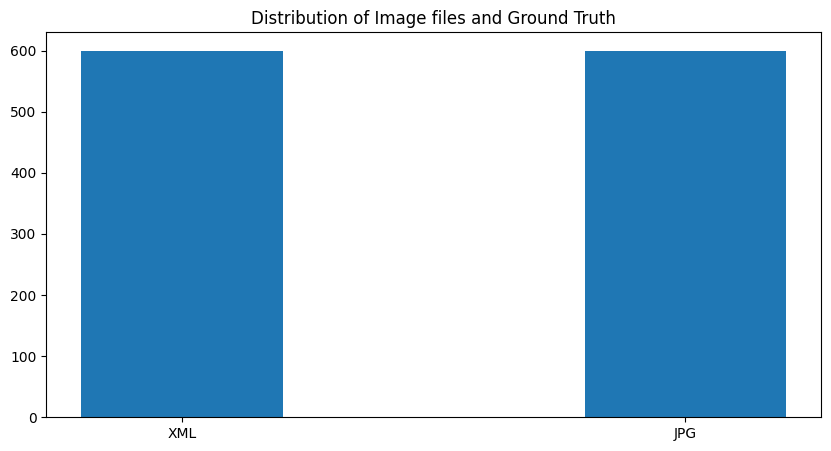

In [72]:
fig = plt.figure(figsize = (10, 5))

x = ['XML', 'JPG']
y = [len(xmls), len(jpgs)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Image files and Ground Truth')
plt.show()

In [7]:
new_h, new_w = 1024, 1024

In [ ]:
def trailplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

# Define the closed areas
  closed_areas = resultant
# Draw the closed areas in white
  for area in closed_areas:
    draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

## Data Preprocessing

In [86]:
import xml.etree.ElementTree as ET


In [85]:
processed_data = []

for i, data in enumerate([jpgs]):
    
    for j, img_path in tqdm(enumerate(data)):
        
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        # table_bboxes, col_bboxes = [], []
            
        #get xml filename
        xml_file = image_name.replace('.jpg', '.xml')
        xml_path = os.path.join(ORIG_DATA_PATH, xml_file)
        xml_file.replace(" ", "")

        #processing XML
        tree = ET.parse(xml_file)
        root = tree.getroot()

        tables, all_points, max_col = getall(root)

        crds = toplot(all_points, max_col)
        colmask, tablemask = os.path.join(COL_MASK_PATH, image_name), os.path.join(TABLE_MASK_PATH, image_name)
        trailplot(crds, img_path, colmask)
        trailplot(tables, img_path, tablemask)
        # print(xml_path, w, h)
            
        #     #get table boxes
            # table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))
        #     # print("column Path: ", column_xml_path)
        #     # print("Table Path: ", table_xml_path)
        #     #get column boxes , if table boxes are empty, approximate them using column boxes
        #     if os.path.exists(column_xml_path):
        #         col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)
        #         # print("col_bboxes: ", col_bboxes)
        #     else:
        #         # print("In else")
        #         col_bboxes = []
            
        # #generate masks
        # table_mask = create_mask(new_h, new_w, table_bboxes)
        # # col_mask = create_mask(new_h, new_w, [[110, 202, 220, 344], [271, 202, 291, 343], [305, 201, 419, 344]])
        # col_mask = create_mask(new_h, new_w, col_bboxes)
        # # print("test: ", type( [[110, 202, 220, 344], [271, 202, 291, 343], [305, 201, 419, 344]]))
        # # image = cv2.imread(col_mask)
        # # cv2.imshow(col_mask, image)
        # # plt.imshow(col_mask) 
        # # print(type(table_mask))
        # # plt.imshow(table_mask) 
#####################################################################################    
        # #save images and masks
        # if col_mask.mode != 'RGB':
        #     col_mask = col_mask.convert('RGB')
        # if table_mask.mode != 'RGB':
        #     table_mask = table_mask.convert('RGB')
        # save_image_path = os.path.join(IMAGE_PATH, image_name.replace('bmp', 'jpg'))
        # save_table_mask_path = os.path.join(TABLE_MASK_PATH, image_name[:-4] + '_table_mask.png')
        # save_col_mask_path = os.path.join(COL_MASK_PATH, image_name[:-4] + '_col_mask.png')
        # # save_image_path = os.path.join("./Trail", image_name.replace('bmp', 'jpg'))
        # # save_table_mask_path = os.path.join("./Trail", image_name[:-4] + '_table_mask.png')
        # # save_col_mask_path = os.path.join("./Trail", image_name[:-4] + '_col_mask.png')
        
        # image.save(save_image_path)
        # table_mask.save(save_table_mask_path)
        # col_mask.save(save_col_mask_path)
        
        # #add data to dataframe
        # len_table = len(table_bboxes)
        # len_cols = len(col_bboxes)

        # value = (save_image_path, save_table_mask_path, save_col_mask_path, h, w, int(len_table != 0), \
        #          len_table, len_cols, table_bboxes, col_bboxes)
        
        # processed_data.append(value)
        
        # if j == 10:
            # break
    # if i == 4:
        # break

1it [00:00,  3.57it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00000.xml 4912 3584


2it [00:00,  3.45it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00001.xml 4912 3584


3it [00:00,  3.56it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00002.xml 4912 3584


4it [00:01,  3.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00003.xml 4912 3584


5it [00:01,  3.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00004.xml 4912 3584


6it [00:01,  3.67it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00005.xml 4912 3584


7it [00:01,  3.78it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00006.xml 4912 3584


8it [00:02,  3.77it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00007.xml 4912 3584


9it [00:02,  4.03it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00008.xml 4912 3584


10it [00:02,  4.18it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00009.xml 4912 3584


11it [00:02,  4.34it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00010.xml 4912 3584


12it [00:03,  3.54it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00018.xml 4355 3418


13it [00:03,  2.73it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00019.xml 5148 3921


14it [00:04,  2.38it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00020.xml 4863 3612


15it [00:04,  2.45it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00021.xml 4149 3296


16it [00:04,  2.80it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00022.xml 2006 3127


17it [00:05,  2.61it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00023.xml 5110 3996


18it [00:06,  2.06it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00024.xml 5862 4380


19it [00:06,  1.83it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00025.xml 4706 3644


20it [00:07,  1.97it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00026.xml 3983 3074


21it [00:08,  1.61it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00027.xml 5651 4407


22it [00:08,  1.63it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00028.xml 5705 4254


23it [00:09,  1.85it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00029.xml 4247 3225


24it [00:09,  1.91it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00030.xml 4273 3336


25it [00:09,  2.12it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00031.xml 4270 3129


26it [00:10,  1.76it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00032.xml 5141 4103


27it [00:11,  2.03it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00033.xml 2117 2985


28it [00:11,  2.15it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00034.xml 2831 4422


29it [00:11,  2.22it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00035.xml 2845 4266


30it [00:12,  2.51it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00036.xml 2012 3329


31it [00:12,  2.35it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00037.xml 3240 4760


32it [00:12,  2.63it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00038.xml 2085 3393


34it [00:13,  3.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00039.xml 2080 3254
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00040.xml 1526 1977


35it [00:13,  3.54it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00041.xml 2256 3559


36it [00:14,  2.82it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00042.xml 4084 3302


37it [00:14,  2.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00043.xml 4787 3939


38it [00:15,  2.30it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00044.xml 5132 4087


39it [00:15,  2.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00045.xml 4114 3538


40it [00:15,  2.27it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00046.xml 4622 3788


41it [00:16,  2.09it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00047.xml 5123 3821


42it [00:16,  2.26it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00048.xml 4163 3433


43it [00:17,  2.24it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00049.xml 5096 4169


44it [00:17,  2.16it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00050.xml 5935 4617


45it [00:18,  2.29it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00051.xml 4656 3672


46it [00:18,  2.49it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00052.xml 5971 4640


48it [00:18,  3.29it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00053.xml 5214 3396
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00054.xml 4039 3321


49it [00:19,  3.30it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00055.xml 5436 4326


51it [00:19,  3.93it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00056.xml 5285 4189
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00057.xml 2573 3936


53it [00:20,  4.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00058.xml 4902 3750
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00059.xml 4250 3214


54it [00:20,  4.63it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00060.xml 2450 3752


55it [00:20,  4.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00061.xml 5033 4130


56it [00:20,  4.05it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00062.xml 5186 4202


58it [00:21,  4.20it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00063.xml 5112 4006
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00064.xml 4164 3515


59it [00:21,  4.12it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00065.xml 5067 3669


60it [00:21,  4.29it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00066.xml 4722 3731
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00067.xml 4247 3338


62it [00:22,  4.73it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00068.xml 3951 3088


63it [00:22,  4.39it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00069.xml 5319 4179


64it [00:22,  4.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00070.xml 4206 3480


65it [00:22,  4.48it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00091.xml 4544 3510


66it [00:23,  4.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00092.xml 4544 3510


68it [00:23,  4.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00093.xml 4544 3510
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00094.xml 4497 3510


70it [00:23,  4.82it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00095.xml 4498 3510
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00096.xml 4498 3510


72it [00:24,  4.92it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00097.xml 4498 3510
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00098.xml 4498 3510


73it [00:24,  4.81it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00099.xml 4498 3510


74it [00:24,  4.79it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00100.xml 4498 3510


75it [00:24,  4.82it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00101.xml 4498 3510


77it [00:25,  5.38it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00116.xml 3508 4963
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00117.xml 3508 4963


79it [00:25,  6.81it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00118.xml 3508 4963
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00119.xml 3508 4963


81it [00:25,  7.23it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00120.xml 3508 4963
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00121.xml 3508 4963


82it [00:25,  7.50it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00122.xml 3508 4963


83it [00:26,  3.77it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00125.xml 8152 5369


84it [00:27,  2.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00126.xml 8238 5483


85it [00:28,  1.87it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00127.xml 8191 5431


86it [00:29,  1.66it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00128.xml 8226 5452


87it [00:29,  1.54it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00129.xml 8253 5396


88it [00:30,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00130.xml 8270 5428


89it [00:31,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00131.xml 8260 5471


90it [00:32,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00132.xml 8172 5419


91it [00:32,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00133.xml 8315 5496


92it [00:33,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00134.xml 8225 5450


93it [00:34,  1.38it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00135.xml 8220 5447


94it [00:34,  1.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00136.xml 8196 5461


95it [00:35,  1.40it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00137.xml 8343 5559


96it [00:36,  1.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00138.xml 8264 5460


97it [00:37,  1.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00139.xml 8158 5429


98it [00:37,  1.42it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00140.xml 8219 5441


99it [00:38,  1.42it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00141.xml 8274 5450


100it [00:39,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00142.xml 8230 5441


101it [00:39,  1.42it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00143.xml 8487 5545


102it [00:40,  1.42it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00144.xml 8210 5477


103it [00:41,  1.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00145.xml 8417 5526


104it [00:41,  1.57it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00167.xml 4156 6336


105it [00:42,  1.76it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00168.xml 6140 3832


107it [00:42,  2.20it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00169.xml 5648 5922
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00170.xml 4072 2501


108it [00:43,  2.39it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00171.xml 3380 5581


109it [00:43,  2.12it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00172.xml 6904 5198


110it [00:44,  1.64it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00173.xml 8414 7662


111it [00:45,  1.54it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00174.xml 6468 6845


112it [00:45,  1.87it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00177.xml 4096 2731


113it [00:45,  2.28it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00178.xml 4096 2731


114it [00:46,  2.71it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00179.xml 4096 2731


115it [00:46,  2.98it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00180.xml 2731 4096


116it [00:46,  3.28it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00181.xml 2731 4096


117it [00:47,  3.02it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00182.xml 2731 4096


118it [00:47,  3.06it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00183.xml 4096 2731


119it [00:47,  2.87it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00184.xml 4096 2731


120it [00:48,  2.86it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00185.xml 2731 4096


121it [00:48,  2.87it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00186.xml 2484 4096


122it [00:48,  3.15it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00187.xml 2484 4096


123it [00:49,  3.14it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00188.xml 2484 4096


124it [00:49,  3.23it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00189.xml 2484 4096


125it [00:49,  3.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00190.xml 2484 4096


126it [00:49,  3.12it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00191.xml 4096 3275


127it [00:50,  2.99it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00192.xml 2731 4096


128it [00:50,  3.29it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00198.xml 3188 2300


129it [00:51,  2.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00199.JPG 4000 6000


130it [00:51,  2.14it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00200.JPG 4000 6000


131it [00:52,  1.87it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00201.JPG 4000 6000


132it [00:53,  1.84it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00202.JPG 4000 6000


133it [00:53,  1.80it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00203.JPG 4000 6000


134it [00:54,  1.70it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00204.JPG 4000 6000


135it [00:54,  1.71it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00205.JPG 4000 6000


136it [00:55,  1.65it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00206.JPG 4000 6000


137it [00:56,  1.72it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00207.JPG 4000 6000


138it [00:56,  1.70it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00208.JPG 4000 6000


139it [00:57,  1.51it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00209.JPG 4000 6000


140it [00:57,  1.90it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00228.xml 2495 4086


141it [00:58,  2.26it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00229.xml 2494 4086


142it [00:58,  2.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00230.xml 2494 4086


144it [00:58,  3.12it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00231.xml 2495 4086
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00232.xml 2494 4086


145it [00:59,  3.64it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00233.xml 2413 3977


147it [00:59,  4.25it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00234.xml 2413 3977
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00235.xml 2413 3977


149it [00:59,  4.75it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00236.xml 2413 3977
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00237.xml 2413 3977


150it [00:59,  5.06it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00238.xml 2413 3977


152it [01:00,  4.96it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00239.xml 2413 3977
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00240.xml 2413 3977


154it [01:00,  4.88it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00241.xml 2413 3977
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00242.xml 2413 3977


155it [01:01,  4.36it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00243.xml 2495 4086


157it [01:01,  4.47it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00244.xml 2494 4086
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00245.xml 2417 2967


159it [01:01,  5.49it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00246.xml 2417 2967
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00247.xml 2419 2967


160it [01:02,  4.63it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00254.xml 2136 2647


162it [01:02,  4.67it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00255.xml 2135 2657
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00256.xml 2133 2656


163it [01:02,  4.56it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00257.xml 2131 2635


164it [01:03,  4.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00258.xml 2129 2631


165it [01:03,  4.04it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00259.xml 2101 2616


166it [01:03,  3.52it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00260.xml 2119 2623


167it [01:03,  3.81it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00261.xml 2067 2625


168it [01:04,  4.01it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00262.xml 2153 2627


169it [01:04,  3.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00263.xml 2139 2637


170it [01:04,  3.71it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00264.xml 2138 2634


172it [01:05,  4.40it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00265.xml 2138 2633
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00266.xml 2137 2633


174it [01:05,  4.82it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00267.xml 2136 2633
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00268.xml 2104 2617


175it [01:05,  4.66it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00269.xml 2136 2633


177it [01:06,  4.96it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00270.xml 2133 2636
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00271.xml 2139 2629


178it [01:06,  4.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00272.xml 2137 2629


179it [01:06,  4.48it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00273.xml 2133 2635


180it [01:06,  4.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00274.xml 2132 2626


181it [01:07,  3.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00275.xml 2128 2626


182it [01:07,  3.65it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00276.xml 2129 2626


183it [01:07,  3.13it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00277.xml 2125 2619


184it [01:08,  3.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00278.xml 2121 2603


186it [01:08,  3.64it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00279.xml 2109 2621
.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00280.xml 2142 2632


187it [01:08,  3.96it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00281.xml 2141 2633


188it [01:09,  4.16it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00282.xml 2137 2635


189it [01:09,  4.36it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00283.xml 2138 2635


190it [01:09,  4.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00284.xml 2137 2639


191it [01:10,  2.31it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00304.xml 8177 6218


192it [01:11,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00305.xml 8188 6222


193it [01:12,  1.34it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00306.xml 8201 6241


194it [01:13,  1.24it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00307.xml 8302 6198


195it [01:14,  1.09it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00308.xml 8268 6151


196it [01:15,  1.03it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00309.xml 8313 6205


197it [01:16,  1.02it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00310.xml 8308 6224


198it [01:17,  1.04it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00311.xml 8311 6229


199it [01:18,  1.02it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00312.xml 8352 6230


200it [01:21,  1.50s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00313.xml 8316 6181


201it [01:22,  1.32s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00314.xml 8330 6227


202it [01:24,  1.51s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00315.xml 8334 6226


203it [01:25,  1.33s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00316.xml 8329 6216


204it [01:26,  1.27s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00317.xml 8352 6219


205it [01:27,  1.16s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00318.xml 8337 6234


206it [01:28,  1.08s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00319.xml 8336 6191


207it [01:29,  1.07s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00320.xml 8334 6192


208it [01:30,  1.07s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00321.xml 8319 6254


209it [01:30,  1.08it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00343.xml 5829 4460


210it [01:31,  1.21it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00344.xml 5829 4476


211it [01:32,  1.30it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00345.xml 5857 4465


212it [01:32,  1.41it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00346.xml 5833 4469


213it [01:33,  1.50it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00347.xml 5849 4471


214it [01:33,  1.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00348.xml 5821 4462


215it [01:34,  1.64it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00349.xml 5829 4464


216it [01:35,  1.60it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00350.xml 5833 4481


217it [01:35,  1.71it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00351.xml 5821 4481


218it [01:36,  1.75it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00352.xml 5817 4463


219it [01:36,  1.69it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00353.xml 5829 4463


220it [01:37,  1.68it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00354.xml 5841 4508


221it [01:37,  1.77it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00355.xml 5853 4468


222it [01:38,  1.85it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00356.xml 5845 4481


223it [01:38,  1.93it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00357.xml 5881 4492


224it [01:39,  1.95it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00358.xml 5857 4481


225it [01:39,  1.95it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00359.xml 5845 4475


226it [01:40,  1.82it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00360.xml 5857 4463


227it [01:41,  1.73it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00361.xml 5857 4463


228it [01:41,  1.68it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00362.xml 5829 4463


229it [01:42,  1.53it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00363.xml 5829 4451


230it [01:42,  1.61it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00364.xml 5865 4463


231it [01:43,  1.49it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00365.xml 5873 4482


232it [01:44,  1.59it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00366.xml 5853 4471


233it [01:45,  1.51it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00367.xml 5865 4475


234it [01:45,  1.51it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00368.xml 5861 4466


235it [01:46,  1.60it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00369.xml 5861 4490


236it [01:46,  1.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00370.xml 5849 4478


237it [01:50,  1.48s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00371.xml 5849 4490


238it [01:51,  1.32s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00372.xml 5865 4475


239it [01:52,  1.19s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00373.xml 5861 4466


240it [01:52,  1.06s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00388.xml 6416 4780


241it [01:53,  1.03s/it]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00389.xml 6482 4780


242it [01:54,  1.08it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00390.xml 5388 4202


243it [01:55,  1.24it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00391.xml 4212 3148


244it [01:55,  1.39it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00392.xml 4212 3148


245it [01:56,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00393.xml 4274 3226


246it [01:56,  1.72it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00394.xml 4274 3226


247it [01:57,  1.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00395.xml 5458 4182


248it [01:58,  1.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00396.xml 5458 4182


249it [01:58,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00397.xml 4059 3109


250it [01:59,  1.66it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00398.xml 4003 3127


251it [02:00,  1.38it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00403.xml 3251 4859


252it [02:01,  1.21it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00404.xml 3251 4859


253it [02:02,  1.19it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00405.xml 3251 4859


254it [02:03,  1.17it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00406.xml 3251 4859


255it [02:03,  1.15it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00407.xml 3251 4859


256it [02:04,  1.18it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00408.xml 3251 4859


257it [02:05,  1.20it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00409.xml 3251 4859


258it [02:06,  1.18it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00410.xml 3251 4859


259it [02:07,  1.11it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00411.xml 3251 4859


260it [02:08,  1.13it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00412.xml 3251 4859


261it [02:09,  1.18it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00413.xml 3251 4859


262it [02:09,  1.20it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00414.xml 3251 4859


263it [02:10,  1.27it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00415.xml 3251 4859


264it [02:11,  1.27it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00416.xml 3251 4859


265it [02:11,  1.36it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00417.xml 3251 4859


266it [02:12,  1.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00418.xml 3251 4859


267it [02:13,  1.54it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00419.xml 3251 4859


268it [02:13,  1.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00420.xml 3251 4859


269it [02:14,  1.61it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00421.xml 3251 4859


270it [02:14,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00422.xml 3251 4859


271it [02:15,  1.57it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00423.xml 3251 4859


272it [02:16,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00424.xml 3251 4859


273it [02:16,  1.47it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00425.xml 3251 4859


274it [02:17,  1.49it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00426.xml 3251 4859


275it [02:18,  1.48it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00427.xml 3251 4859


276it [02:18,  1.50it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00428.xml 3251 4859


277it [02:19,  1.50it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00429.xml 3251 4859


278it [02:20,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00430.xml 3251 4859


279it [02:20,  1.57it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00431.xml 3251 4859


280it [02:21,  1.57it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00432.xml 3251 4859


281it [02:22,  1.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00433.xml 3251 4859


282it [02:22,  1.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00434.xml 3251 4859


283it [02:23,  1.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00435.xml 3251 4859


284it [02:24,  1.53it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00436.xml 3251 4859


285it [02:24,  1.53it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00437.xml 3251 4859


286it [02:25,  1.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00438.xml 3251 4859


287it [02:25,  1.51it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00439.xml 3251 4859


288it [02:26,  1.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00440.xml 3251 4859


289it [02:27,  1.59it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00441.xml 3251 4859


290it [02:27,  1.60it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00442.xml 3251 4859


291it [02:28,  1.62it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00443.xml 3251 4859


292it [02:28,  1.81it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00448.JPG 2848 4288


293it [02:29,  1.95it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00449.JPG 2848 4288


294it [02:29,  2.04it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00450.JPG 2848 4288


295it [02:30,  2.15it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00451.JPG 2848 4288


296it [02:30,  2.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00452.JPG 2848 4288


297it [02:30,  2.22it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00453.JPG 2848 4288


298it [02:31,  2.38it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00454.JPG 2848 4288


299it [02:31,  2.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00455.JPG 2848 4288


300it [02:32,  2.40it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00456.JPG 2848 4288


301it [02:32,  2.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00457.JPG 2848 4288


302it [02:33,  2.19it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00458.JPG 2848 4288


303it [02:33,  2.37it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00459.JPG 2848 4288


304it [02:33,  2.45it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00460.JPG 2848 4288


305it [02:34,  2.58it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00461.JPG 2848 4288


306it [02:34,  2.65it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00462.JPG 2848 4288


307it [02:34,  2.61it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00463.JPG 2848 4288


308it [02:35,  2.45it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00464.JPG 2848 4288


309it [02:35,  2.47it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00465.JPG 2848 4288


310it [02:36,  2.44it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00466.JPG 2848 4288


311it [02:36,  2.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00467.JPG 2848 4288


312it [02:36,  2.39it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00468.JPG 2848 4288


313it [02:37,  2.23it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00469.JPG 2848 4288


314it [02:37,  2.36it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00470.JPG 2848 4288


315it [02:38,  2.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00471.JPG 2848 4288


316it [02:38,  2.32it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00472.JPG 2848 4288


317it [02:39,  1.92it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00473.JPG 2848 4288


318it [02:39,  2.10it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00474.JPG 2848 4288


319it [02:40,  2.15it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00475.JPG 2848 4288


320it [02:40,  2.16it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00476.JPG 2848 4288


321it [02:40,  2.52it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00501.xml 3504 2479


322it [02:41,  2.46it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00502.xml 3414 5378


323it [02:41,  2.47it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00503.xml 3390 5378


324it [02:42,  2.43it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00504.xml 5428 3559


325it [02:42,  2.48it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00505.xml 5209 3244


326it [02:42,  2.55it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00506.xml 5246 2869


327it [02:43,  2.36it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00507.xml 5186 3099


328it [02:43,  2.26it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00508.xml 3073 5174


329it [02:44,  2.26it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00509.xml 5330 3268


330it [02:44,  2.24it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00510.xml 3354 5341


331it [02:45,  2.28it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00511.xml 3454 5441


332it [02:45,  1.94it/s]

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00512.xml 6500 4969


332it [02:46,  2.00it/s]


KeyboardInterrupt: 

In [69]:

column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
processed_data = pd.DataFrame(processed_data, columns=column_name)

In [74]:
processed_data.to_csv("processed_data.csv", index = False)

In [75]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,marmot_processed\image\10.1.1.1.2000_4.jpg,marmot_processed\table_mask\10.1.1.1.2000_4_ta...,marmot_processed\col_mask\10.1.1.1.2000_4_col_...,1008,768,0,0,0,[],[]
1,marmot_processed\image\10.1.1.1.2004_4.jpg,marmot_processed\table_mask\10.1.1.1.2004_4_ta...,marmot_processed\col_mask\10.1.1.1.2004_4_col_...,1123,793,0,0,0,[],[]
2,marmot_processed\image\10.1.1.1.2004_5.jpg,marmot_processed\table_mask\10.1.1.1.2004_5_ta...,marmot_processed\col_mask\10.1.1.1.2004_5_col_...,1123,793,0,0,0,[],[]
3,marmot_processed\image\10.1.1.1.2005_12.jpg,marmot_processed\table_mask\10.1.1.1.2005_12_t...,marmot_processed\col_mask\10.1.1.1.2005_12_col...,1056,816,0,0,0,[],[]
4,marmot_processed\image\10.1.1.1.2005_13.jpg,marmot_processed\table_mask\10.1.1.1.2005_13_t...,marmot_processed\col_mask\10.1.1.1.2005_13_col...,1056,816,0,0,0,[],[]


In [76]:
processed_data = pd.read_csv('processed_data.csv')

In [77]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,marmot_processed\image\10.1.1.1.2000_4.jpg,marmot_processed\table_mask\10.1.1.1.2000_4_ta...,marmot_processed\col_mask\10.1.1.1.2000_4_col_...,1008,768,0,0,0,[],[]
1,marmot_processed\image\10.1.1.1.2004_4.jpg,marmot_processed\table_mask\10.1.1.1.2004_4_ta...,marmot_processed\col_mask\10.1.1.1.2004_4_col_...,1123,793,0,0,0,[],[]
2,marmot_processed\image\10.1.1.1.2004_5.jpg,marmot_processed\table_mask\10.1.1.1.2004_5_ta...,marmot_processed\col_mask\10.1.1.1.2004_5_col_...,1123,793,0,0,0,[],[]
3,marmot_processed\image\10.1.1.1.2005_12.jpg,marmot_processed\table_mask\10.1.1.1.2005_12_t...,marmot_processed\col_mask\10.1.1.1.2005_12_col...,1056,816,0,0,0,[],[]
4,marmot_processed\image\10.1.1.1.2005_13.jpg,marmot_processed\table_mask\10.1.1.1.2005_13_t...,marmot_processed\col_mask\10.1.1.1.2005_13_col...,1056,816,0,0,0,[],[]


## Advanced EDA

In [ ]:
processed_data['hasTable'].value_counts().tolist()

#### Positive : Negative Ratio

In [ ]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [ ]:
processed_data[(processed_data['table_count']==0)]

#### Table with No Columns

In [ ]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

#### plotting image with table but no columns

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

In [ ]:
processed_data['original_height'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_height'], color='b', fill=True)
  
plt.xlabel('Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Image

In [ ]:
processed_data['original_width'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_width'], color='b', fill=True)

plt.xlabel('Width')
plt.ylabel('Probability Density')
plt.show()

### Total Tables

In [ ]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

In [ ]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [ ]:
import json


### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.

### Height of Table

In [ ]:
heights = []
widths = []
for boxes in processed_data[processed_data['hasTable']==1]['table_bboxes']:
    # boxes = [json.loads('[' + boxes.strip('][').strip(',') + ']')]
    print(boxes)
# Convert the cleaned string to a Python list
# array = json.loads('[' + cleaned_string + ']')
    # for box in boxes:
    #     heights.append(box[3]-box[1])
    #     widths.append(box[2]-box[0])

In [ ]:
min(col_widths)

In [ ]:
sns.histplot(heights, color='b', Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(heights, color='b', shade=True, Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Table

In [ ]:
sns.histplot(widths, color='b', Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(widths, color='b', shade=True, Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Probability Density')
plt.show()

### Height of the Column

In [ ]:
col_heights = []
col_widths = []
for boxes in processed_data[processed_data['hasTable']==1]['col_bboxes']:
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

In [ ]:
sns.histplot(col_heights, color='b', Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_heights, color='b', shade=True, Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Column

In [ ]:
sns.histplot(col_widths, color='b', Label='Column Width')

plt.xlabel('Column Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_widths, color='b', shade=True, Label='Table Column')

plt.xlabel('Table Column')
plt.ylabel('Probability Density')
plt.show()

### Observations

- Height of tables ranges from 30 - 870, but most are between  50-300.
- Width of tables ranges from 50 - 900, but common width is 400.
- Height of columns ranges from 10 - 880 showing a right skewed distribution
- Width of columns ranges from 7 - 671 showing a right skewed distribution